Dataset: [here](https://www.kaggle.com/datasets/rdoume/beerreviews)

Dataset [here](https://www.kaggle.com/datasets/stephenpolozoff/top-beer-information/code)

##Importing modules


In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=25d859a6fadb5144d446fd2f3b97fa5bf5daf218f20faa90f2226ed547031ab1
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import concat, col
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


#Initializing SparkSession and reading the dataset

In [3]:
spark = SparkSession.builder.appName("Read CSV with PySpark").getOrCreate()
def read_csv(file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)

csv_file_paths = ["beer_reviews.csv", "beer_data_set.csv"]
dataframes = list(map(read_csv, csv_file_paths))
for i, df in enumerate(dataframes):
    print(f"DataFrame {i + 1}:")
    df.show()

df1 = dataframes[0]
df2 = dataframes[1]

DataFrame 1:
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|          beer_style|review_palate|review_taste|           beer_name|beer_abv|beer_beerid|
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|     10325|     Vecchio Birraio| 1234817823|           1.5|         2.0|              2.5|           stcules|          Hefeweizen|          1.5|         1.5|        Sausa Weizen|     5.0|      47986|
|     10325|     Vecchio Birraio| 1235915097|           3.0|         2.5|              3.0|           stcules|  English Strong Ale|          3.0|         3.0|            Red Moon|    

#Searching for missing values

In [4]:
def count_missing(df):
    missing_counts = {}
    for col in df.columns:
        missing_count = df.where(F.col(col).isNull()).count()
        missing_counts[col] = missing_count
    return missing_counts
print("Part 1: Count of Missing Values")
def show_missing():
  for i, df in enumerate(dataframes):
      print(f"DataFrame {i + 1}:")
      missing_counts = count_missing(df)
      for col, count in missing_counts.items():
          print(f"{col}: {count}")
      print()
show_missing()

Part 1: Count of Missing Values
DataFrame 1:
brewery_id: 0
brewery_name: 0
review_time: 0
review_overall: 0
review_aroma: 0
review_appearance: 0
review_profilename: 13
beer_style: 0
review_palate: 0
review_taste: 0
beer_name: 0
beer_abv: 2553
beer_beerid: 0

DataFrame 2:
Name: 2
key: 0
Style: 0
Style Key: 0
Brewery: 0
Description: 0
ABV: 0
Ave Rating: 0
Min IBU: 0
Max IBU: 0
Astringency: 0
Body: 0
Alcohol: 0
Bitter: 0
Sweet: 0
Sour: 0
Salty: 0
Fruits: 0
Hoppy: 0
Spices: 0
Malty: 0



#Dropping missing values

In [5]:
def drop_na():
  for i, df in enumerate(dataframes):
      dataframes[i] = df.dropna()
drop_na()
show_missing()

DataFrame 1:
brewery_id: 0
brewery_name: 0
review_time: 0
review_overall: 0
review_aroma: 0
review_appearance: 0
review_profilename: 0
beer_style: 0
review_palate: 0
review_taste: 0
beer_name: 0
beer_abv: 0
beer_beerid: 0

DataFrame 2:
Name: 0
key: 0
Style: 0
Style Key: 0
Brewery: 0
Description: 0
ABV: 0
Ave Rating: 0
Min IBU: 0
Max IBU: 0
Astringency: 0
Body: 0
Alcohol: 0
Bitter: 0
Sweet: 0
Sour: 0
Salty: 0
Fruits: 0
Hoppy: 0
Spices: 0
Malty: 0



#Creating unique key for both datasets, which contains information about brewery name and style of a beer

In [6]:
df2 = df2.withColumn("BreweryStyle", concat(col("Brewery"), col("style")))
print("DataFrame with new column 'BreweryStyle':")
df2.show()
df1 = df1.withColumn("BreweryStyle", concat(col("brewery_name"), col("beer_style")))
print("DataFrame with new column 'BreweryStyle':")
df1.show()


DataFrame with new column 'BreweryStyle':
+--------------------+---+-------+---------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+--------------------+
|                Name|key|  Style|Style Key|             Brewery|         Description|                 ABV|Ave Rating|             Min IBU|             Max IBU|Astringency|Body|Alcohol|Bitter|Sweet|Sour|Salty|Fruits|Hoppy|Spices|Malty|        BreweryStyle|
+--------------------+---+-------+---------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+--------------------+
|               Amber|251|Altbier|        8| Alaskan Brewing Co.|"Notes:Richly mal...|                 5.3|      3.65|                  25|                  50|         13|  32|      9|  

#Concatenating dataframes based on unique id

In [7]:
mapped_df = df1.join(df2, df2["BreweryStyle"] == df1["BreweryStyle"], "inner")
print("Mapped DataFrame:")
mapped_df.show()

Mapped DataFrame:
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+------------+-------------+------------+--------------------+--------+-----------+--------------------+----------+---+------------+---------+--------------------+--------------------+---+----------+-------+-------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+--------------------+
|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|  beer_style|review_palate|review_taste|           beer_name|beer_abv|beer_beerid|        BreweryStyle|      Name|key|       Style|Style Key|             Brewery|         Description|ABV|Ave Rating|Min IBU|Max IBU|Astringency|Body|Alcohol|Bitter|Sweet|Sour|Salty|Fruits|Hoppy|Spices|Malty|        BreweryStyle|
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+------------+-------------+---

#Creating a new column, which combines rating of a beer from two datasets and gives mean of those 2 values. Beforehand it replaces all non numeric values inside this coulmn with a mean of this column

In [8]:
columns_to_process = ["review_overall", "Ave Rating"]
def calculate_mean(df, col_name):
    numeric_values = df.filter(df[col_name].cast("float").isNotNull())
    sum_count = numeric_values.select(F.sum(col_name).alias('sum'), F.count(col_name).alias('count')).collect()[0]
    total_sum = sum_count['sum']
    total_count = sum_count['count']
    mean_value = total_sum / total_count
    return mean_value

def replace_non_numeric_with_mean(df, col_name, mean_value):
    df = df.withColumn(col_name, F.when(df[col_name].cast("float").isNotNull(), df[col_name]).otherwise(mean_value))
    return df


def process_dataframe(df):
    for col in columns_to_process:
        mean_value = calculate_mean(df, col)
        df = replace_non_numeric_with_mean(df, col, mean_value)
    return df

mapped_df = process_dataframe(mapped_df)


mapped_df = mapped_df.withColumn("overall_average",
                                 (F.col("review_overall").cast("float") + F.col("Ave Rating").cast("float")) / 2)


print("Mapped DataFrame after processing:")
mapped_df.show()

Mapped DataFrame after processing:
+----------+--------------------+-----------+--------------+------------+-----------------+------------------+------------+-------------+------------+--------------------+--------+-----------+--------------------+----------+---+------------+---------+--------------------+--------------------+---+----------+-------+-------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+--------------------+-----------------+
|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|  beer_style|review_palate|review_taste|           beer_name|beer_abv|beer_beerid|        BreweryStyle|      Name|key|       Style|Style Key|             Brewery|         Description|ABV|Ave Rating|Min IBU|Max IBU|Astringency|Body|Alcohol|Bitter|Sweet|Sour|Salty|Fruits|Hoppy|Spices|Malty|        BreweryStyle|  overall_average|
+----------+--------------------+-----------+--------------+------------+--------------

#Displaying Top 10 breweries based on average rating

In [10]:
spark = SparkSession.builder.appName("Top Breweries by Mean Rating").getOrCreate()
mapped_df2 = mapped_df.groupBy("brewery_id") \
                      .agg(F.mean("overall_average").alias("brewery_mean_rating"))

mapped_df2_top10 = mapped_df2.orderBy(F.desc("brewery_mean_rating")) \
                             .limit(10)
top10_with_names = mapped_df2_top10.join(mapped_df.select("brewery_id", "brewery_name").distinct(), "brewery_id", "left") \
                                   .select("brewery_id", "brewery_name", "brewery_mean_rating")


print("Top 10 Breweries by Mean Rating:")
top10_with_names.show()


Top 10 Breweries by Mean Rating:
+----------+--------------------+-------------------+
|brewery_id|        brewery_name|brewery_mean_rating|
+----------+--------------------+-------------------+
|      1199|Founders Brewing ...|  4.100182919693314|
|     15636|Calapooia Brewing...| 3.9533332188924155|
|       140|Sierra Nevada Bre...| 3.9476500864751034|
|     16866|          The Bruery|  3.911328013216863|
|       577|Isle Of Skye Brewery|   3.86578947619388|
|       729|Palmetto Brewing ...|  3.759999990463257|
|       394| Stoudts Brewing Co.|  3.759957399774105|
|       161|Florida Beer Company|  3.704999828338623|
|       339|Flying Fish Brewi...|  3.704202773630755|
|     14879|Hoppin' Frog Brewery|    3.6636991441063|
+----------+--------------------+-------------------+



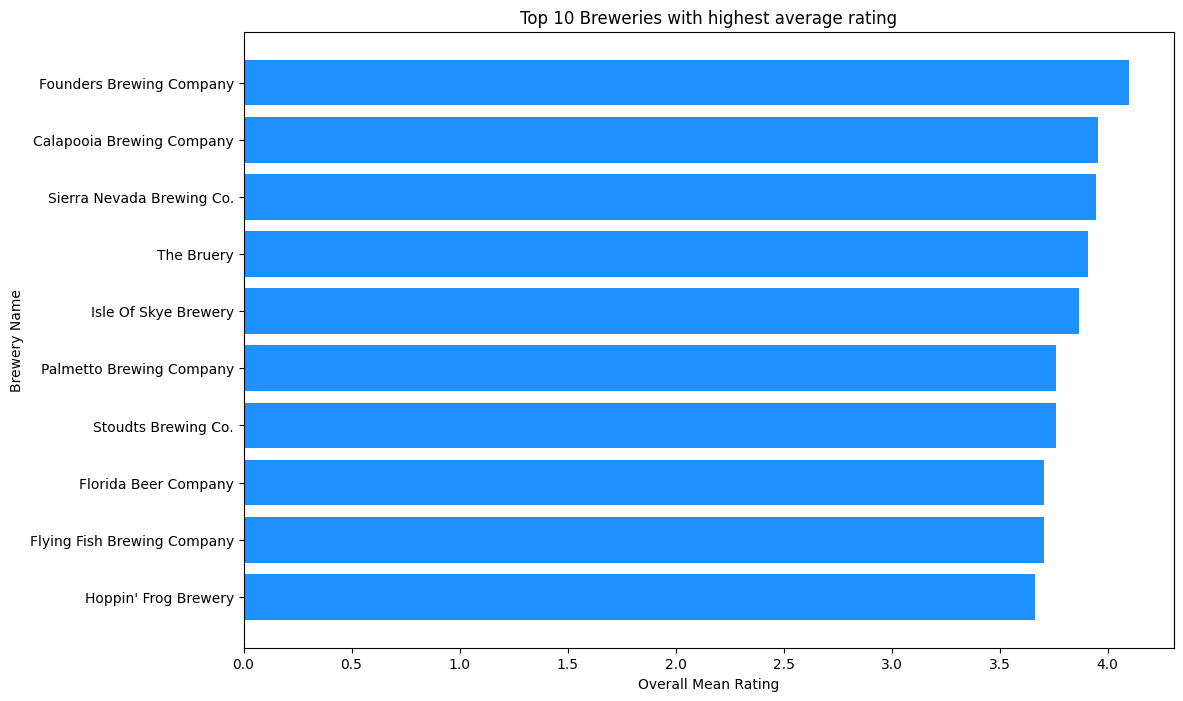

In [25]:
top10_with_names_pd = top10_with_names.toPandas()

top10_with_names_pd = top10_with_names_pd.sort_values(by="brewery_mean_rating", ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(top10_with_names_pd['brewery_name'], top10_with_names_pd['brewery_mean_rating'], color='#1E90FF')
plt.xlabel('Overall Mean Rating')
plt.ylabel('Brewery Name')
plt.title('Top 10 Breweries with highest average rating')
plt.gca().invert_yaxis()
plt.show()

#Top 10 beer styles based on average rating

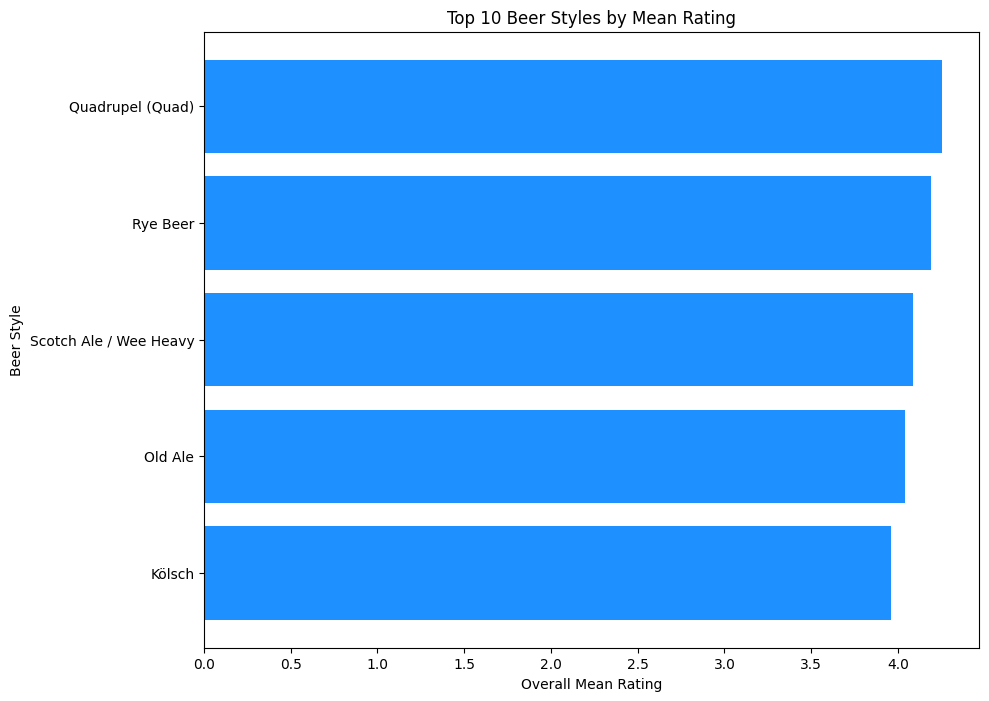

In [24]:
styles_df = mapped_df.groupBy("beer_style") \
                     .agg(F.mean("overall_average").alias("style_mean_rating"))


styles_df_top5 = styles_df.orderBy(F.desc("style_mean_rating")).limit(5)


styles_df_top5_pd = styles_df_top5.toPandas()


styles_df_top5_pd = styles_df_top5_pd.sort_values(by="style_mean_rating", ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(styles_df_top5_pd['beer_style'], styles_df_top5_pd['style_mean_rating'], color='#1E90FF')
plt.xlabel('Overall Mean Rating')
plt.ylabel('Beer Style')
plt.title('Top 10 Beer Styles by Mean Rating')
plt.gca().invert_yaxis()
plt.show()

#Seleting columns to perform machine learning

In [26]:
columns_to_select = ["Min IBU", "Max IBU", "Astringency", "Body", "Alcohol", "Bitter", "Sweet", "Sour", "Salty", "Fruits", "Hoppy", "Spices", "Malty","overall_average"]
selected_df = mapped_df.select(columns_to_select)
for col_name in columns_to_select:
    selected_df = selected_df.withColumn(col_name, col(col_name).cast("integer"))
selected_df.show()

+-------+-------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+---------------+
|Min IBU|Max IBU|Astringency|Body|Alcohol|Bitter|Sweet|Sour|Salty|Fruits|Hoppy|Spices|Malty|overall_average|
+-------+-------+-----------+----+-------+------+-----+----+-----+------+-----+------+-----+---------------+
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              3|
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              4|
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              3|
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              3|
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              4|
|      9|     25|         14|  71|     13|    51|   76|  17|    0|    32|   34|    18|  108|              3|
|      9|     25|  

#Machine Learning

Performing machine learning, to predict rating of a beer with performance evaluation metrics(RMSE,R2,Intercept) also displaying coeficients for each feature. This code is also available for docker, adjust hdfs ath, and run docker file(also in this git hub folder)

In [27]:
spark = SparkSession.builder \
    .appName("Beer Ratings Linear Regression") \
    .getOrCreate()

# hdfs_path = "path to this file" to run docker file, adjust this path

columns_to_select = ["Min IBU", "Max IBU", "Astringency", "Body", "Alcohol",
                     "Bitter", "Sweet", "Sour", "Salty", "Fruits", "Hoppy",
                     "Spices", "Malty", "overall_average"]

selected_df = mapped_df.select(columns_to_select)

for col_name in columns_to_select:
    selected_df = selected_df.withColumn(col_name, col(col_name).cast("integer"))

feature_columns = columns_to_select[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
assembled_df = assembler.transform(selected_df.na.drop(subset=feature_columns))


(training_data, test_data) = assembled_df.randomSplit([0.8, 0.2], seed=1234)
lr = LinearRegression(featuresCol="features", labelCol="overall_average")


lr_model = lr.fit(training_data)

predictions = lr_model.transform(test_data)


evaluator = RegressionEvaluator(labelCol="overall_average", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 0.45508062607183275
Coefficients: [0.017348540780726066,0.01821001479173194,0.01201626735288886,0.009427166016958003,0.0034909141462331024,-0.032941330039395554,-0.011838108028770292,-0.027757358367532653,-0.09383986460549891,0.0199951707888611,0.008243057052669221,-0.009764134532767938,0.011527902997282326]
Intercept: 2.461824550192584
R-squared (R2): 0.26585467940289687
